In [1]:
import sys
import os

# Add the root directory of your project to the Python path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), "..")))

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from binance.client import Client
import ta
from xgboost import XGBClassifier
import joblib

from bot.backtest import run_directional_backtest  
from bot.strategy import WeightedStrategy  
from bot.utils import load_config
from notebooks.Feature_engineering import prepare_features
from bot.Indicators import RSIIndicator
from bot.Indicators import MACDIndicator
from bot.Indicators import MLIndicator
from bot.Indicators import BollingerIndicator
from bot.Indicators import StochasticKIndicator
from bot.Indicators import ATRVolatilityIndicator
from bot.Indicators import ROCIndicator
from bot.Indicators import OBVIndicator
from bot.Indicators import MFIIndicator
from bot.Indicators import RollingVolatilityIndicator
from bot.Indicators import PriceMomentumIndicator

import datetime


In [3]:
config=load_config("../config/config.yaml")
# Connexion au client Binance
client = Client(config["api_key"], config["api_secret"])
klines = client.get_historical_klines(
    symbol=config["symbol"],
    interval=Client.KLINE_INTERVAL_15MINUTE,
    start_str="2024-12-01 00:00:00",
    end_str="2025-06-03 00:00:00"
)
columns = ["timestamp", "open", "high", "low", "close", "volume",
           "close_time", "quote_asset_volume", "number_of_trades",
           "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume", "ignore"]
df = pd.DataFrame(klines, columns=columns)

# Conversion du timestamp en format lisible
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")

# Sélectionner uniquement les colonnes importantes
df = df[["timestamp", "open", "high", "low", "close", "volume"]]
df_max=prepare_features(df)

In [26]:
print(df_max.head())

            timestamp      open      high       low     close     volume  \
0 2024-12-01 08:15:00  96717.21  97179.04  96688.00  96950.00  675.97894   
1 2024-12-01 08:30:00  96949.99  97096.00  96750.00  97024.24  574.47682   
2 2024-12-01 08:45:00  97024.24  97168.00  97000.00  97048.01  184.91393   
3 2024-12-01 09:00:00  97048.00  97098.53  96862.83  96954.15  157.25934   
4 2024-12-01 09:15:00  96954.15  97011.99  96864.00  96887.92  123.55592   

         sma_14        ema_14        macd  macd_signal  ...  rolling_mean  \
0  96462.934286  96500.906570   81.247308    30.228656  ...  96462.934286   
1  96507.621429  96570.684361  115.303757    47.243676  ...  96507.621429   
2  96552.620000  96634.327779  142.568339    66.308609  ...  96552.620000   
3  96589.403571  96676.970742  154.817362    84.010359  ...  96589.403571   
4  96630.767143  96705.097310  157.366569    98.681601  ...  96630.767143   

   rolling_std  rolling_skew  rolling_kurt  close_lag1  close_lag2  \
0   171.87

In [4]:
# Load your model features
feature_names = [
     'open', 'high', 'low', 'close', 'volume', 'sma_14',
       'ema_14', 'macd', 'macd_signal', 'macd_diff', 'rsi', 'stoch_k',
       'stoch_d', 'roc', 'atr', 'bollinger_mavg', 'bollinger_hband',
       'bollinger_lband', 'bollinger_width', 'obv', 'mfi', 'rolling_mean',
       'rolling_std', 'rolling_skew', 'rolling_kurt', 'close_lag1',
       'close_lag2', 'close_lag3', 'close_lag4'
]

# Define indicator list and weights (adjust weights as needed)
indicators = [
    RSIIndicator(),
    MACDIndicator(),
    MLIndicator(model_path="/Users/raph4/crypto-bot/crypto-bot/notebooks/xgb_model_optuna.pkl",feature_names=feature_names),
    BollingerIndicator(),
StochasticKIndicator(),
ATRVolatilityIndicator(),
ROCIndicator(),
OBVIndicator(),
MFIIndicator(),
RollingVolatilityIndicator(),
PriceMomentumIndicator()
    # Add your 10 best indicator classes here
]

weights = [1/13,1/13,3/13,1/13,1/13,1/13,1/13,1/13,1/13,1/13,1/13]

# Create the strategy
strategy = WeightedStrategy(indicators=indicators, weights=weights, thresholdhigh=0.65, thresholdlow=0.35)


In [5]:

results, sharpe = run_directional_backtest(
    df=df_max,
    strategy=strategy,
    start="2025-01-01",
    end="2025-06-01"
)


🔍 Sharpe Ratio (risk-free=0): 2.1050


In [15]:
results.head()

,timestamp,signal,close,position,return,strategy_return,cumulative_strategy,cumulative_market,drawdown,true_direction,correct
0,2025-01-01 00:00:00,buy,93656.18,1,0.001129,0.001129,1.001129,1.001129,0.0,1,1
1,2025-01-01 00:15:00,notrade,93761.90,0,0.001313,0.000000,1.001129,1.002443,0.0,1,0
2,2025-01-01 00:30:00,notrade,93885.01,0,0.005497,0.000000,1.001129,1.007954,0.0,1,0
3,2025-01-01 00:45:00,notrade,94401.14,0,-0.002628,-0.000000,1.001129,1.005305,0.0,0,1
4,2025-01-01 01:00:00,notrade,94153.05,0,-0.003475,-0.000000,1.001129,1.001812,0.0,0,1


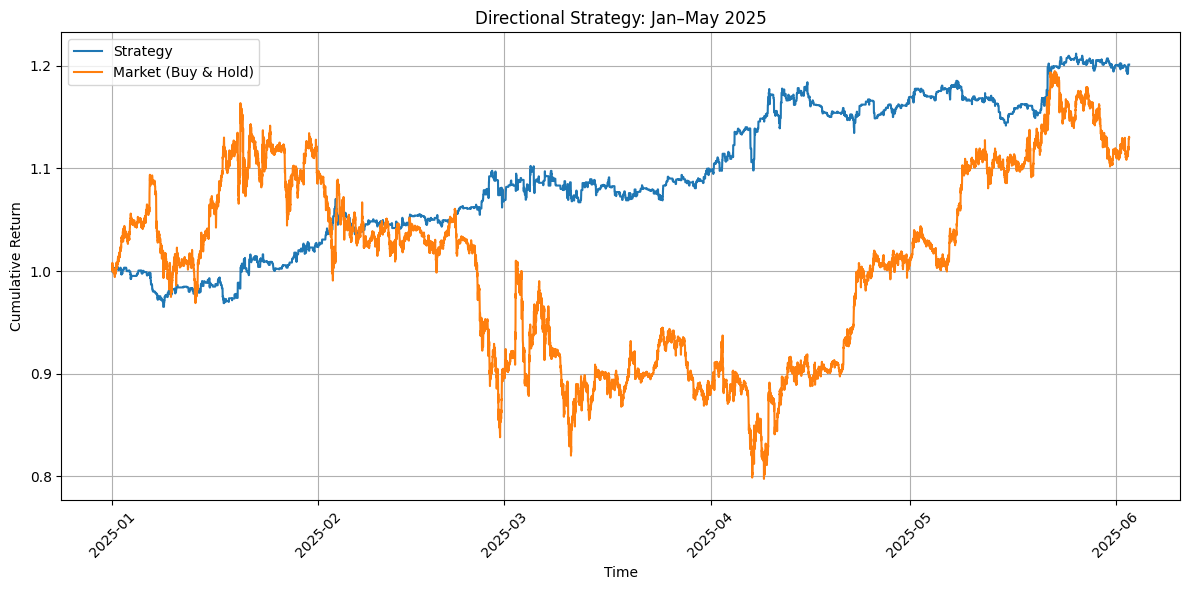

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(results["timestamp"], results["cumulative_strategy"], label="Strategy")
plt.plot(results["timestamp"], results["cumulative_market"], label="Market (Buy & Hold)")
plt.title("Directional Strategy: Jan–May 2025")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Max Drawdown'}>

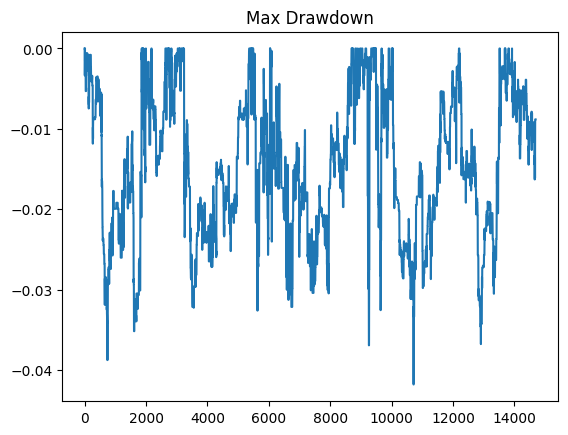

In [8]:
results["drawdown"] = results["cumulative_strategy"] / results["cumulative_strategy"].cummax() - 1
results["drawdown"].plot(title="Max Drawdown")


In [9]:
final_return = results["cumulative_strategy"].iloc[-2]
market_return = results["cumulative_market"].iloc[-2]
print(f"📈 Strategy Return: {final_return:.2f} | Market: {market_return:.2f}")


📈 Strategy Return: 1.20 | Market: 1.13


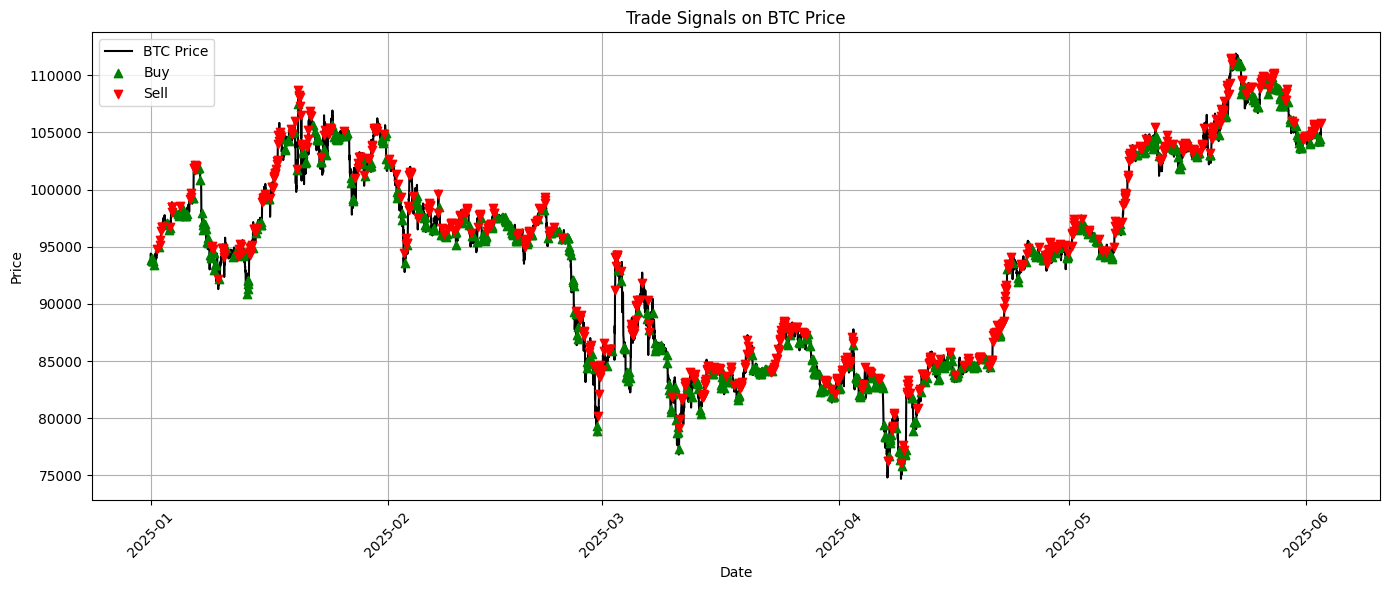

In [26]:
results["entry"] = results["position"].diff().fillna(0)
buy_signals = results[(results["entry"] == 2) | ((results["entry"] == 1) & (results["position"] == 1))]
sell_signals = results[(results["entry"] == -2) | ((results["entry"] == -1) & (results["position"] == -1))]
plt.figure(figsize=(14, 6))
plt.plot(results["timestamp"], results["close"], label="BTC Price", color='black')

# Plot buys
plt.scatter(buy_signals["timestamp"], buy_signals["close"], marker="^", color="green", label="Buy", zorder=3)

# Plot sells (or short entries)
plt.scatter(sell_signals["timestamp"], sell_signals["close"], marker="v", color="red", label="Sell", zorder=3)

plt.title("Trade Signals on BTC Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [24]:
results["true_direction"] = (results["return"] > 0).astype(int)
trades_only = results[results["signal"].isin(["buy", "sell"])].copy()
trades_only["correct"] = ((trades_only["position"] > 0).astype(int) == trades_only["true_direction"]).astype(int)
accuracy = trades_only["correct"].mean()
print(f"🎯 Strategy Accuracy (on trades only): {accuracy:.2%}")
print(f"📊 Number of trades: {len(trades_only)}")
print(f"🕐 Trade frequency: {100 * len(trades_only)/len(results):.2f}% of periods")



🎯 Strategy Accuracy (on trades only): 51.03%
📊 Number of trades: 1993
🕐 Trade frequency: 13.57% of periods


In [25]:
trades_only.head()

,timestamp,signal,close,position,return,strategy_return,cumulative_strategy,cumulative_market,drawdown,true_direction,correct
0,2025-01-01 00:00:00,buy,93656.18,1,0.001129,0.001129,1.001129,1.001129,0.000000,1,1
5,2025-01-01 01:15:00,buy,93825.86,1,0.001037,0.001037,1.002167,1.002850,0.000000,1,1
6,2025-01-01 01:30:00,buy,93923.14,1,-0.003358,-0.003358,0.998801,0.999483,-0.003358,0,0
7,2025-01-01 01:45:00,buy,93607.74,1,0.002054,0.002054,1.000853,1.001536,-0.001311,1,1
8,2025-01-01 02:00:00,buy,93800.00,1,-0.000613,-0.000613,1.000240,1.000922,-0.001923,0,0


In [27]:
buy_accuracy = trades_only[trades_only["signal"] == "buy"]["correct"].mean()
sell_accuracy = trades_only[trades_only["signal"] == "sell"]["correct"].mean()
print(buy_accuracy,sell_accuracy)

0.4978723404255319 0.5213675213675214


In [10]:
results["true_direction"] = (results["return"] > 0).astype(int)
results["correct"] = ((results["strategy_return"] > 0).astype(int) == results["true_direction"]).astype(int)
accuracy = results["correct"].mean()
print(f"✅ Strategy Accuracy: {accuracy:.2%}")


✅ Strategy Accuracy: 49.43%


In [30]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(trades_only["true_direction"], (trades_only["position"] > 0).astype(int)))
print(classification_report(trades_only["true_direction"], (trades_only["position"] > 0).astype(int)))


[[549 472]
 [504 468]]
              precision    recall  f1-score   support

           0       0.52      0.54      0.53      1021
           1       0.50      0.48      0.49       972

    accuracy                           0.51      1993
   macro avg       0.51      0.51      0.51      1993
weighted avg       0.51      0.51      0.51      1993



In [31]:
active_returns = results[results["position"] != 0]["strategy_return"].dropna()

In [39]:
if active_returns.std() != 0 and len(active_returns) > 1:
    mean_return = active_returns.mean()
    std_return = active_returns.std()
    periods_per_year = 96 * 252  # still assume annualized based on trade frequency
    active_sharpe_ratio = (mean_return / std_return) * np.sqrt(periods_per_year)
    print( active_sharpe_ratio)

5.717842045464758


In [41]:
print(f"number of trade :{len(active_returns)}")
print("Mean:", active_returns.mean())
print("Std:", active_returns.std())
print("Sharpe:", active_sharpe_ratio)

number of trade :1992
Mean: 9.5366363746649e-05
Std: 0.0025941731298392595
Sharpe: 5.717842045464758
